



# Simulateur SVOM

Dans le cadre de la mission SVOM (Space Variable Objects Monitor) de détection de sursauts gamma plusieurs détecteurs, caméras et téléscopes ont été choisis pour des observations sur terre. Grâce à ce simulateur et ce tutoriel vous avez accès à des simulations de ce que peuvent nous donner ces différents instruments lors de phases de test (champ sombre, champ plat, ...) ou lors d'observations (données collectées grâce à différentes mesures sur les différents téléscopes).

## Sommaire :
1. Fichiers de configuration
2. Simulation d'une image    
3. Simulation d'une rampe    
4. Simulation d'un bruit CDS

A réaliser au départ absolument :

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
from ImSimpy.ImSimpy import ImageSimulator

# 1. Fichiers de configuration

Dans le dossier *ImSimpy/ImSimpy/configFiles* et *pyETC/pyETC/telescope_database* se trouve des fichiers *.hjson* qui sont des fichiers de configuration. Vous pourrez par la suite choisir de simuler une rampe ou un bruit CDS (cf. 3ème partie ou 4ème partie respectivement).

Dans le dossier *ImSimpy/ImSimpy/configFiles* vous pouvez choisir de simuler des champs sombre (*Dark.hjson*), des champs plat (*Flat.hjson*), des images réalisées sur un temps très court pour mesurer le bruit de lecture (Texp=0s, *Bias.hjson*). Vous pouvez aussi décider de créer votre propre fichier .hjson en remplissant vous même le fichier *Make_one_image_is.hjson* (is pour image simulator). Dans ce fichier vous pouvez choisir parmis des paramètres de calcul, choisir des conditions locale comme la température ou l'élévation de la lune et des paramètres du téléscope comme le seeing ou des paramètres de caméras.

Le fichier pris par défault est un Dark :  [Dark.hjson](../ImSimpy/configFiles/Dark.hjson)

*Remarque :* C'est à l'intérieur de ces fichiers que l'on choisit l'emplacement des fichiers .fits de configurations (carte des facteurs de conversion, des pixels morts et chauds dans le cas d'une simulation d'image simple, vignettage, offset). 

Dans le dossier *pyETC/pyETC/telescope_database* vous pouvez choisir le téléscope (associé à sa/ses caméra/s). Par exemple, pour simuler des images du détecteur Teledyne il faut choisir *colibri_teledyne.hjson* et pour simuler des images faites par la caméra de Sofradir choisissez *colibri.hjson*.

Le téléscope choisi par défault est :  [colibri_teledyne.hjson](../../pyETC/pyETC/telescope_database/colibri_teledyne.hjson)

*Remarque :* C'est à l'intérieur de ces fichiers que l'on doit placer certains coefficients importants comme la taille des pixels, la largeur des bandes de pixels de référence ou les neufs coefficients de diaphonie interpixel.

Dans la cellule ci-dessous vous pouvez donc choisir votre type de mesure et votre téléscope en remplaçant `Dark.hjson` et `'colibri_teledyne'` par ce que vous souhaitez.

In [3]:
Simulation=ImageSimulator(configFile=os.getenv('ImSimpy_DIR')+'/ImSimpy/configFiles/Dark.hjson',
                          name_telescope='colibri_teledyne')

Setting the random number generator seed: current time


L'objet est stocké dans la variable "Simulation". Cela peut être n'importe quoi d'autre.

Si vous n'avez pas le répertoire standard, vous devez spécifier le chemin où se trouve le fichier de configuration. Prenons l'exemple ci-dessous.

# 2. Simulation d'une image

L'image est enregistrée dans le dossier *ImSimpy/images* et vous devez placez le nom ci-dessous :

In [4]:
#File name
Simulation.nom = 'Dark'

#Read the configfile
Simulation.readConfigs()

#execute it:
Simulation.simulate()

Read config file and execute ETC
Building image: Dark.fits:
	Add dark current
	Add cosmetics
	Apply Saturation
	Add Readout Noise
	electrons2adu
	Add offset
	Discretise
	Write outputs


Pour récupérer le nom de l'image simulée :

In [5]:
fits_filename=os.getenv('ImSimpy_DIR')+'/ImSimpy/images/'+Simulation.information['output']
print (fits_filename)

C:\Users\stagiaire\Documents\Projet Git\ImSimpy/ImSimpy/images/Dark.fits


Visualisation de l'image :

<IPython.core.display.Javascript object>


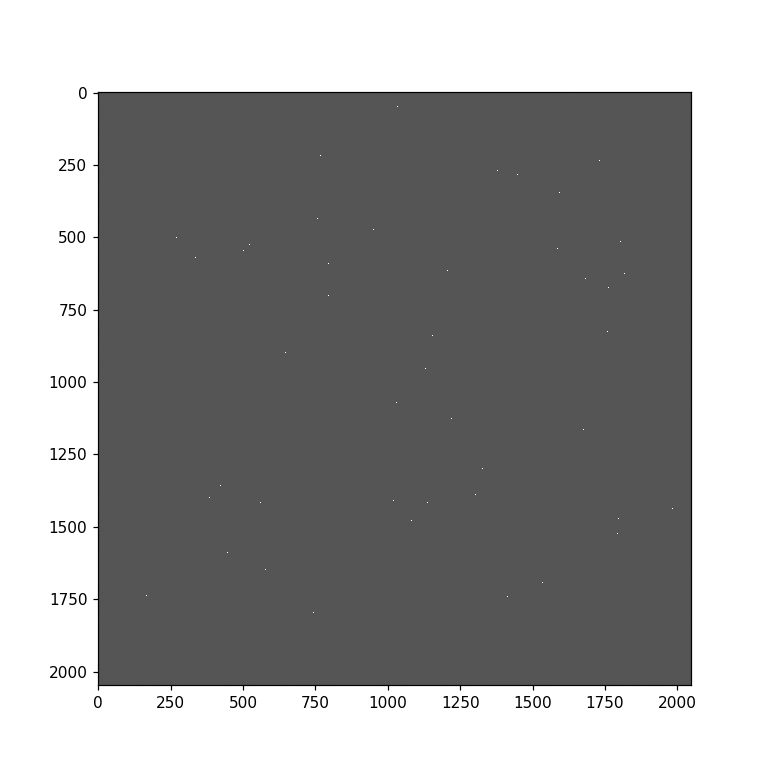

In [6]:
from astropy.io import fits
import numpy as np

fits_file = fits.getdata(fits_filename)
image_mean = np.mean(fits_file)
image_std = np.std(fits_file)
vmin = image_mean - 5*image_std
vmax = image_mean + 10*image_std
plt.figure(figsize=(7,7))
plt.imshow(fits_file,interpolation='none',cmap='gray',vmin=vmin,vmax=vmax)

Ajout des coordonées universelles (wcs) :

In [ ]:
from astropy.wcs import WCS

image,header = fits.getdata(fits_filename,header=True)

wcs = WCS(header)
plt.figure(figsize=(7,7))

plt.subplot(projection=wcs)
plt.imshow(image,interpolation='none',cmap='gray',vmin=vmin,vmax=vmax,origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension (J2000)')
plt.ylabel('Declination (J2000)')

Le principal paramètre pour la vitesse de calcul est le facteur de suréchantillonnage. Plus il est grand, plus le calcul sera lent.

Notez que le code n'a été testé que pour des sources ponctuelles. Il reste encore du travail à faire pour inclure des sources étendues.

# 3. Simulation d'une rampe

Pour simuler une rampe choisissez dans un premier temps un type de mesure et un téléscope (cf 1ère partie). Remplacez ci-dessous dans la variable `Simulation` le type et le téléscope choisis.

Ensuite, dans la variable `bands` placez un tableau avec les bandes spectrales que vous souhaitez du système photométrique. Voici un tableau comportant toutes les bandes (par défault seule la bande J est choisie) : 
        
        bands= ['g','r','i','z','y','J','H'] 
Dans la variable `output_dir` placez le nom du dossier dans lequel la rampe sera enregistrée dans le dossier images de ImSimpy (vous devez créer le dossier auparavant).

Choisissez enfin les paramètres et placez les dans les variables suivantes:
   * nombre de reset : `nbReset`
   * nombre d'image (appartenant à la rampe) : `nbImages` 
                   OU
   * nombre de reset : `nbReset`
   * durée de la rampe (secondes) : `durée`

In [4]:
from ImSimpy.ImSimpy import ImageSimulator

Simulation=ImageSimulator(configFile=os.getenv('ImSimpy_DIR')+'/ImSimpy/configFiles/Dark.hjson',
                          name_telescope='colibri_teledyne')

Simulation.bands = ['J']

Simulation.output_dir='H2RGSim'

Simulation.nbReset=1
Simulation.nbImages=10

Simulation.readConfigs()
Simulation.config['verbose'] = 'False'

for band in Simulation.bands:
    
    # Select appropriate channel for the selected filter band
    if band in ['g','r','i']:
        Simulation.config['channel']='DDRAGO-B'    
    elif band in ['z','y']:
        Simulation.config['channel']='DDRAGO-R'
    elif band in['J','H']:
        Simulation.config['channel']='CAGIRE'
        
    # Set filter band
    Simulation.config['filter_band']=band
    
    # Simulation
    Simulation.Rampsimulation('data')


Setting the random number generator seed: current time
Read config file and execute ETC


KeyError: 'c1'

### Visualisation

In [14]:
from astropy.io import fits
from astropy.visualization import  AsinhStretch

# Create multiplot
fig, ax = plt.subplots(len(Simulation.bands), Simulation.nbImages, figsize=(10,10))

for i, band in enumerate(Simulation.bands):
    for j, t in range(Simulation.nbImages):
        
        filename = fits_filename=os.getenv('ImSimpy_DIR')+'/ImSimpy/images/'+'%s/image_%s_%s.fits' % (output_dir,band,t)
        
        image,header = fits.getdata(fits_filename,header=True)
        image_mean = np.mean(image)
        image_std = np.std(image)
        vmin = image_mean - 1*image_std
        vmax = image_mean + 10*image_std

        norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

        ax[i,j].imshow(image,interpolation='none',cmap='gray',origin='lower', norm=norm)
        #ax[i,j].grid(color='white', ls='solid')
        ax[i,j].text(550,1750,'%s band, Texp=%.1f s' % (band,t), color='C1')
        #ax[i,j].set_xlabel('Right Ascension (J2000)')
        #ax[i,j].set_ylabel('Declination (J2000)')

plt.tight_layout()

<IPython.core.display.Javascript object>

TypeError: 'int' object is not iterable

# 4. Bruit CDS